# Modèle SVM pour détecter les risques de cancer cervical
par Binh Minh TRAN

## 1. Importation des packages nécessaires

In [1]:
# 1. Manipulation des données
import numpy as np
import pandas as pd

# 2. Sérialisation des objets Python
import pickle

# 3. Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Prétraitement des données
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 5. Modélisation
from sklearn import svm
from sklearn.svm import SVC

# 6. Évaluation du modèle (Model Evaluation)
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report,precision_score, recall_score

# 7. Validation croisée et recherche de paramètres
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit

# 8. Traitement des étiquettes
from sklearn.preprocessing import label_binarize

# 9. Outils supplémentaires
from collections import Counter

# 10. Fonctions personnalisées
from fonctionUtile import * 

# 11,
from tabulate import tabulate

## 2. Importation des ensembles d'entraînement et de test

In [2]:
with open('Variables/variables.pkl', 'rb') as f:
    (df, X_train, X_test, y_train, y_test,X_train_smote, y_train_smote) = pickle.load(f)

## 3. Vérification de la séparation linéaire avec SVM

On explore la structure des données en les transformant d’un espace original vers un espace réduit de 2 dimensions.

Précision sur l'ensemble d'entraînement : 0.88


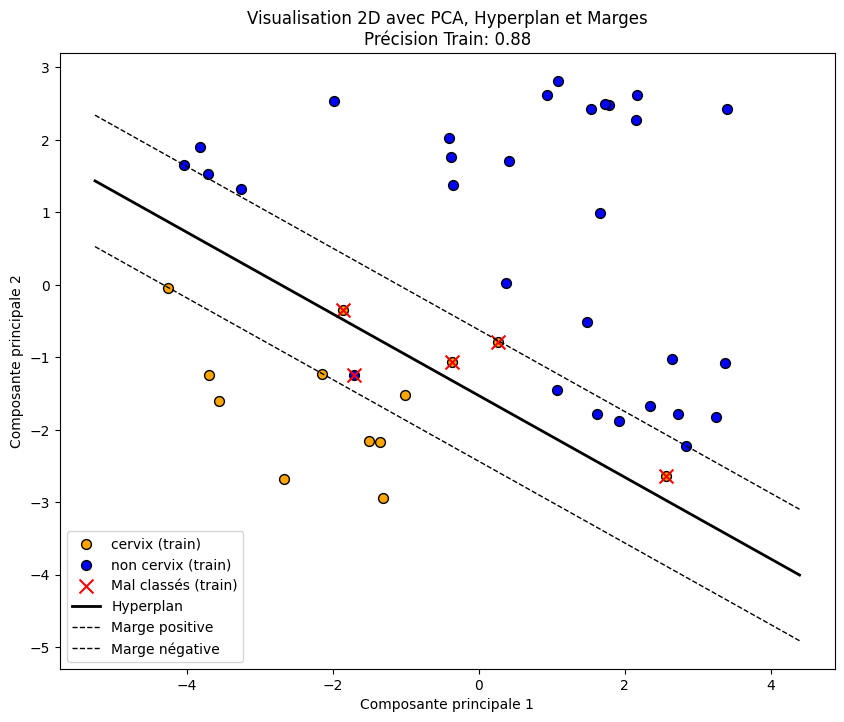

In [3]:
pca_et_visualisation(X_train, y_train)

Évidemment, nous constatons que la séparation linéaire entre 2 classes n’est pas nette, car certains points sont mal classés. De plus, la précision sur l’ensemble d’entraînement avec le noyau linéaire n’est pas proche de 1, ce qui renforce cette observation. Cependant, les données ne sont pas équilibrées entre les deux catégories dans l’ensemble d’entraînement, ce qui peut en partie expliquer pourquoi le noyau linéaire ne parvient pas à bien classer les données. Ainsi, nous appliquons la méthode SMOTE afin d’équilibrer les données, autrement dit, de modifier leur distribution.

Précision sur l'ensemble d'entraînement : 0.93


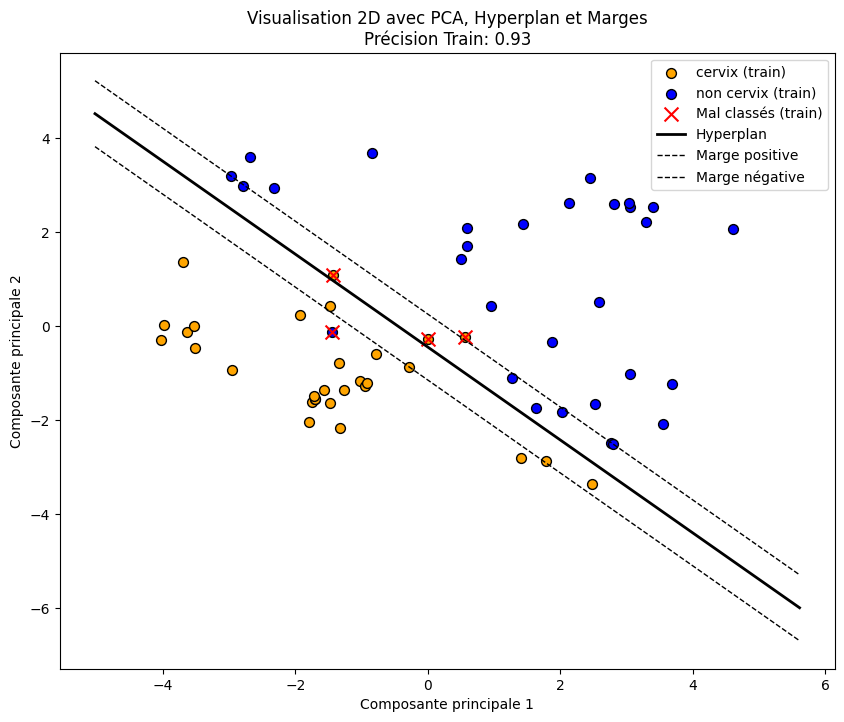

In [4]:
pca_et_visualisation(X_train_smote, y_train_smote)

Après l’application de SMOTE, nous constatons que la distribution des données devient plus équilibrée et que la séparation linéaire est plus nette, avec une précision qui se rapproche de 1. Nous entraînons le modèle sur l’ensemble d’entraînement en utilisant la méthode d’équilibrage des données SMOTE, car cela lui permet d’apprendre davantage d’informations sur la classe minoritaire.

## 4. SVM

### 4.1 Optimisation des hyperparamètres de SVM avec K-FOLD Cross-Validation

Selon la vérification de la séparation linéaire, nous ne pouvons pas conclure avec certitude que la séparation est parfaite. Nous décidons donc d'utiliser trois noyaux supplémentaires (RBF, polynomial et sigmoïde) en plus du noyau linéaire pour entraîner le modèle. Ce sont des noyaux non linéaires, ce qui permet de transformer les données dans un espace de dimension supérieure où elles deviennent plus séparables.

In [5]:
kernel = ["linear","rbf","poly","sigmoid"]

Dans l'algorithme de SVM, il existe un hyperparamètre $C$ contrôle le compromis entre la maximisation de la marge et la tolérance aux erreurs lors de l'entraînement.

Afin de trouver le meilleur hyperparamètre $C$ pour chaque noyau, nous définissons une gamme de valeurs possibles pour $C$ (allant de $10^{-2}$ à $10^{10}$). Ensuite, nous entraînons le modèle pour chaque valeur de $C$. De plus, nous appliquons la validation croisée K-Fold avec $K = 5$ dans ce cas. Cette méthode consiste à diviser l’ensemble d’entraînement en $K$ sous-ensembles. À chaque itération (ou pli), un sous-ensemble est utilisé comme ensemble de test, tandis que les $K-1$ autres sous-ensembles servent d'ensemble d'entraînement.

Ainsi, $K$ modèles sont entraînés sur des sous-ensembles d’entraînement distincts (un modèle par pli). La précision moyenne pour une valeur donnée de $C$ est calculée comme suit :

$$
\bar{P}(C) = \frac{1}{K} \sum_{i=1}^{K} P_i(C)
$$

où $P_i(C)$ est la précision du modèle entraîné avec la valeur $C$ sur le **jeu de test** du $i^{\text{ème}}$ pli.

Nous sélectionnons ensuite la meilleure valeur de $C$ en appliquant la règle suivante :

$$
C^* = \arg\max_C \bar{P}(C)
$$

Si plusieurs valeurs de $C$ donnent la même précision moyenne, nous retenons la première rencontrée, car l'ordre n'a pas d'imporance dans ce cas.
re n'a pas d'importance dans ce cas.


In [6]:
def svm_train(X_train, y_train, kernel):
    results = {
        "best_C_values": [],  # Stocke les meilleures valeurs de C trouvées par validation croisée
        "best_model": None,   # Meilleur modèle entraîné
        "grid_search": None   # Objet GridSearchCV utilisé pour la recherche d'hyperparamètres
    }
    
    # Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
   
    svc = SVC(kernel=kernel)  # Création d'un modèle SVM avec le noyau spécifié
    
    # Définition d'une gamme de valeurs pour le paramètre C (de 10^-2 à 10^10)
    C_range = np.logspace(-2, 10, 13)
    param_grid = {'C': C_range}
    
    # Validation croisée avec 5 plis
    cv = KFold(n_splits=5, shuffle=True, random_state=18)
    
    # Recherche du meilleur hyperparamètre C
    grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)  # Entraînement du modèle avec validation croisée
    
    # Extraction du meilleur C et du meilleur modèle trouvé
    best_C = grid_search.best_params_['C']
    best_model = grid_search.best_estimator_
    
    # Stockage des résultats
    results["best_C_values"].append(best_C)
    results["best_model"] = best_model
    results["grid_search"] = grid_search
    
    # Prédiction sur l'ensemble d'entraînement pour évaluer la performance du modèle
    y_pred = best_model.predict(X_train_scaled)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    print("\nPrécision du modèle pour l'ensemble d'entraînement :", accuracy)
    print("F1-score du modèle pour l'ensemble d'entraînement :", f1)
    print("Meilleures valeurs de C :", results["best_C_values"], "\n")
    
    return results

In [7]:
results_dict_smote = {}
for i in kernel:
    print("SVM SMOTE - noyau: ", i)
    results_dict_smote[i] = svm_train(X_train_smote, y_train_smote, i)

SVM SMOTE - noyau:  linear

Précision du modèle pour l'ensemble d'entraînement : 1.0
F1-score du modèle pour l'ensemble d'entraînement : 1.0
Meilleures valeurs de C : [1.0] 

SVM SMOTE - noyau:  rbf

Précision du modèle pour l'ensemble d'entraînement : 1.0
F1-score du modèle pour l'ensemble d'entraînement : 1.0
Meilleures valeurs de C : [1.0] 

SVM SMOTE - noyau:  poly

Précision du modèle pour l'ensemble d'entraînement : 1.0
F1-score du modèle pour l'ensemble d'entraînement : 1.0
Meilleures valeurs de C : [10.0] 

SVM SMOTE - noyau:  sigmoid

Précision du modèle pour l'ensemble d'entraînement : 0.95
F1-score du modèle pour l'ensemble d'entraînement : 0.9508196721311475
Meilleures valeurs de C : [1.0] 



In [8]:
for i, result in results_dict_smote.items():
    print(f"\n==== Résultats pour le noyau : {i} ====")
    print("Meilleurs paramètres :", result["grid_search"].best_params_)
    print("Meilleur score (accuracy) :", result["grid_search"].best_score_)
    
    cv_results_smote = pd.DataFrame(result["grid_search"].cv_results_)
    print(cv_results_smote[['param_C', 'mean_test_score']]) # C et moyenne des précisions


==== Résultats pour le noyau : linear ====
Meilleurs paramètres : {'C': 1.0}
Meilleur score (accuracy) : 0.95
         param_C  mean_test_score
0   1.000000e-02         0.866667
1   1.000000e-01         0.933333
2   1.000000e+00         0.950000
3   1.000000e+01         0.950000
4   1.000000e+02         0.950000
5   1.000000e+03         0.950000
6   1.000000e+04         0.950000
7   1.000000e+05         0.950000
8   1.000000e+06         0.950000
9   1.000000e+07         0.950000
10  1.000000e+08         0.950000
11  1.000000e+09         0.950000
12  1.000000e+10         0.950000

==== Résultats pour le noyau : rbf ====
Meilleurs paramètres : {'C': 1.0}
Meilleur score (accuracy) : 0.9166666666666667
         param_C  mean_test_score
0   1.000000e-02         0.550000
1   1.000000e-01         0.550000
2   1.000000e+00         0.916667
3   1.000000e+01         0.916667
4   1.000000e+02         0.916667
5   1.000000e+03         0.916667
6   1.000000e+04         0.916667
7   1.000000e+05   

In [9]:
results_dict= {}
for i in kernel:
    print("SVM - noyau: ", i)
    results_dict[i] = svm_train(X_train, y_train, i)

SVM - noyau:  linear

Précision du modèle pour l'ensemble d'entraînement : 1.0
F1-score du modèle pour l'ensemble d'entraînement : 1.0
Meilleures valeurs de C : [1.0] 

SVM - noyau:  rbf

Précision du modèle pour l'ensemble d'entraînement : 1.0
F1-score du modèle pour l'ensemble d'entraînement : 1.0
Meilleures valeurs de C : [10.0] 

SVM - noyau:  poly

Précision du modèle pour l'ensemble d'entraînement : 1.0
F1-score du modèle pour l'ensemble d'entraînement : 1.0
Meilleures valeurs de C : [100.0] 

SVM - noyau:  sigmoid

Précision du modèle pour l'ensemble d'entraînement : 0.9302325581395349
F1-score du modèle pour l'ensemble d'entraînement : 0.88
Meilleures valeurs de C : [100.0] 



In [10]:
for i, result in results_dict.items():
    print(f"\n==== Résultats pour le noyau: {i} ====")
    print("Best parameters:", result["grid_search"].best_params_)
    print("Best score:", result["grid_search"].best_score_)
    
    cv_results = pd.DataFrame(result["grid_search"].cv_results_)
    print(cv_results[['param_C', 'mean_test_score']])


==== Résultats pour le noyau: linear ====
Best parameters: {'C': 1.0}
Best score: 0.861111111111111
         param_C  mean_test_score
0   1.000000e-02         0.655556
1   1.000000e-01         0.794444
2   1.000000e+00         0.861111
3   1.000000e+01         0.861111
4   1.000000e+02         0.861111
5   1.000000e+03         0.861111
6   1.000000e+04         0.861111
7   1.000000e+05         0.861111
8   1.000000e+06         0.861111
9   1.000000e+07         0.861111
10  1.000000e+08         0.861111
11  1.000000e+09         0.861111
12  1.000000e+10         0.861111

==== Résultats pour le noyau: rbf ====
Best parameters: {'C': 10.0}
Best score: 0.7972222222222223
         param_C  mean_test_score
0   1.000000e-02         0.700000
1   1.000000e-01         0.700000
2   1.000000e+00         0.750000
3   1.000000e+01         0.797222
4   1.000000e+02         0.797222
5   1.000000e+03         0.797222
6   1.000000e+04         0.797222
7   1.000000e+05         0.797222
8   1.000000e+06 

Avec ces résultats, on peut dire que lorsque $C$ augmente, le classificateur SVM cherche à minimiser les erreurs de classification, ce qui le pousse à classer les données de manière plus stricte. Cependant, dans le cadre du SVM, il existe un concept appelé soft margin, qui permet d’accepter qu’un certain nombre de points soient mal classés ou situés dans la marge. Cela aide à éviter le sur-apprentissage et améliore la capacité de généralisation du modèle.

### 4.2 Entraînement des modèles avec le meilleur paramètre C

Après avoir trouvé la valeur optimale de C pour chaque noyau, nous utilisons l'ensemble d'entraînement déjà divisé (avec un ratio de 60/40 dans le fichier Preparation.ipynb) pour réentraîner le modèle avec la meilleure valeur de C trouvée. Nous allons entrainer l'algorithme SVM avec la méthode SMOTE et sans SMOTE.

In [11]:
print(X_train_smote.shape) #dimension de l'ensemble d'entrainement
print(X_test.shape) #dimension de l'ensemble de test

(60, 19)
(29, 19)


#### 4.2.1 Entraînement des modèles avec la méthode SMOTE

In [12]:
scaler = StandardScaler() # Normalisation des données
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 

In [13]:
svc_best_lin_smote = SVC(C=1, kernel='linear')

svc_best_lin_smote.fit(X_train_scaled, y_train_smote)
y_pred_lin_smote = svc_best_lin_smote.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_lin_smote)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_lin_smote))

Confusion Matrix:
[[20  1]
 [ 0  8]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.89      1.00      0.94         8

    accuracy                           0.97        29
   macro avg       0.94      0.98      0.96        29
weighted avg       0.97      0.97      0.97        29



In [14]:
svc_best_rbf_smote = SVC(C=1, kernel='rbf')

svc_best_rbf_smote.fit(X_train_scaled, y_train_smote)

y_pred_rbf_smote = svc_best_rbf_smote.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_rbf_smote)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_rbf_smote))

Confusion Matrix:
[[20  1]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.88      0.88      0.88         8

    accuracy                           0.93        29
   macro avg       0.91      0.91      0.91        29
weighted avg       0.93      0.93      0.93        29



In [15]:
svc_best_poly_smote = SVC(C=10, kernel='poly')

svc_best_poly_smote.fit(X_train_scaled, y_train_smote)
y_pred_poly_smote = svc_best_poly_smote.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_poly_smote)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_poly_smote))

Confusion Matrix:
[[17  4]
 [ 0  8]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.67      1.00      0.80         8

    accuracy                           0.86        29
   macro avg       0.83      0.90      0.85        29
weighted avg       0.91      0.86      0.87        29



In [16]:
svc_best_sig_smote = SVC(C=1, kernel='sigmoid', probability=True)

svc_best_sig_smote.fit(X_train_scaled, y_train_smote)
y_pred_sig_smote = svc_best_sig_smote.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_sig_smote)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_sig_smote))

Confusion Matrix:
[[18  3]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.70      0.88      0.78         8

    accuracy                           0.86        29
   macro avg       0.82      0.87      0.84        29
weighted avg       0.88      0.86      0.87        29



#### 4.2.2 Entraînement des modèles sans SMOTE

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [18]:
svc_best_lin = SVC(C=1, kernel='linear', probability=True)

svc_best_lin.fit(X_train_scaled, y_train)
y_pred_lin = svc_best_lin.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_lin)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_lin))

Confusion Matrix:
[[20  1]
 [ 0  8]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.89      1.00      0.94         8

    accuracy                           0.97        29
   macro avg       0.94      0.98      0.96        29
weighted avg       0.97      0.97      0.97        29



In [19]:
svc_best_rbf = SVC(C=10, kernel='rbf')

svc_best_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svc_best_rbf.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_rbf)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_rbf))

Confusion Matrix:
[[20  1]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.88      0.88      0.88         8

    accuracy                           0.93        29
   macro avg       0.91      0.91      0.91        29
weighted avg       0.93      0.93      0.93        29



In [20]:
svc_best_poly = SVC(C=100, kernel='poly', probability=True)

svc_best_poly.fit(X_train_scaled, y_train)
y_pred_poly = svc_best_poly.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_poly)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_poly))

Confusion Matrix:
[[21  0]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.88      0.93         8

    accuracy                           0.97        29
   macro avg       0.98      0.94      0.96        29
weighted avg       0.97      0.97      0.96        29



In [21]:
svc_best_sig = SVC(C=100, kernel='sigmoid', probability=True)

svc_best_sig.fit(X_train_scaled, y_train)
y_pred_sig = svc_best_sig.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_sig)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_sig))

Confusion Matrix:
[[18  3]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.70      0.88      0.78         8

    accuracy                           0.86        29
   macro avg       0.82      0.87      0.84        29
weighted avg       0.88      0.86      0.87        29



## 5. Évaluation des modèles

### 5.1 Évaluation du modèle entrainé avec la méthode SMOTE

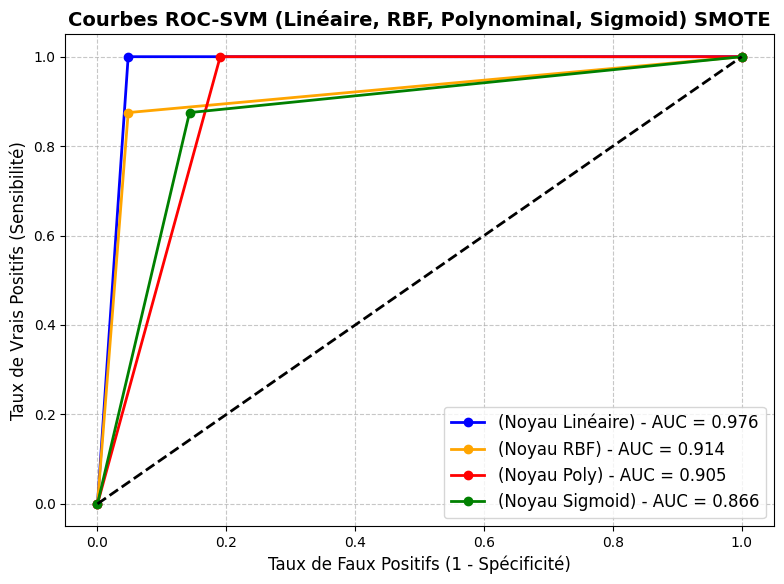

In [22]:
#SMOTE
fpr_lin_smote, tpr_lin_smote, _ = roc_curve(y_test, y_pred_lin_smote)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf_smote, tpr_rbf_smote, _ = roc_curve(y_test, y_pred_rbf_smote)  # ROC pour le modèle SVC avec noyau RBF
fpr_poly_smote, tpr_poly_smote, _ = roc_curve(y_test, y_pred_poly_smote)# ROC pour le modèle SVC avec noyau Poly
fpr_sig_smote, tpr_sig_smote, _ = roc_curve(y_test, y_pred_sig_smote) # ROC pour le modèle SVC avec noyau sigmoid

auc_lin_smote = auc(fpr_lin_smote, tpr_lin_smote)  # AUC pour le modèle SVC avec noyau linéaire
auc_rbf_smote = auc(fpr_rbf_smote, tpr_rbf_smote)  # AUC pour le modèle SVC avec noyau RBF
auc_poly_smote = auc(fpr_poly_smote, tpr_poly_smote)
auc_sig_smote = auc(fpr_sig_smote, tpr_sig_smote)

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin_smote, tpr_lin_smote, label=f'(Noyau Linéaire) - AUC = {auc_lin_smote:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf_smote, tpr_rbf_smote, label=f'(Noyau RBF) - AUC = {auc_rbf_smote:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')
plt.plot(fpr_poly_smote, tpr_poly_smote, label=f'(Noyau Poly) - AUC = {auc_poly_smote:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='red', color='red')
plt.plot(fpr_sig_smote, tpr_sig_smote, label=f'(Noyau Sigmoid) - AUC = {auc_sig_smote:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='green', color='green')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.grid(True, linestyle='--', alpha=0.7)
plt.rcParams['font.size'] = 12
plt.title('Courbes ROC-SVM (Linéaire, RBF, Polynominal, Sigmoid) SMOTE', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM_SMOTE.png")
plt.show()

In [23]:
models_smote = {
    "Linear": y_pred_lin_smote,
    "RBF": y_pred_rbf_smote,
    "Poly": y_pred_poly_smote,
    "Sigmoid": y_pred_sig_smote
}

# Calcul de la précision (Accuracy) pour chaque modèle
accuracy_scores = {kernel: accuracy_score(y_test, y_pred) for kernel, y_pred in models_smote.items()}

# Calcul du F1-score pour chaque modèle
f1_scores = {kernel: f1_score(y_test, y_pred) for kernel, y_pred in models_smote.items()}
recall_scores = {kernel: recall_score(y_test, y_pred) for kernel, y_pred in models_smote.items()}
precision_scores = {kernel: precision_score(y_test, y_pred) for kernel, y_pred in models_smote.items()}

auc_scores = {
    "Linear": auc_lin_smote,
    "RBF": auc_rbf_smote,
    "Poly": auc_poly_smote,
    "Sigmoid": auc_sig_smote
}

# Création d'un DataFrame pour afficher les résultats
df_results_smote = pd.DataFrame({
    "Kernel": accuracy_scores.keys(),
    "Accuracy": [round(acc, 5) for acc in accuracy_scores.values()],
    "F1-score": [round(f1, 5) for f1 in f1_scores.values()],
    "Precision": [round(prec, 5) for prec in precision_scores.values()],
    "Recall": [round(rec, 5) for rec in recall_scores.values()],
    "AUC-ROC": [round(auc_val, 5) for auc_val in auc_scores.values()]
})

# Affichage du tableau des résultats
print("Table de comparaison du modèle SVM avec des noyaux (SMOTE)")
print(tabulate(df_results_smote, headers='keys', tablefmt='pretty', showindex=False))

Table de comparaison du modèle SVM avec des noyaux (SMOTE)
+---------+----------+----------+-----------+--------+---------+
| Kernel  | Accuracy | F1-score | Precision | Recall | AUC-ROC |
+---------+----------+----------+-----------+--------+---------+
| Linear  | 0.96552  | 0.94118  |  0.88889  |  1.0   | 0.97619 |
|   RBF   | 0.93103  |  0.875   |   0.875   | 0.875  | 0.91369 |
|  Poly   | 0.86207  |   0.8    |  0.66667  |  1.0   | 0.90476 |
| Sigmoid | 0.86207  | 0.77778  |    0.7    | 0.875  | 0.86607 |
+---------+----------+----------+-----------+--------+---------+


### 5.2 Évaluation du modèle entrainé sans la méthode SMOTE

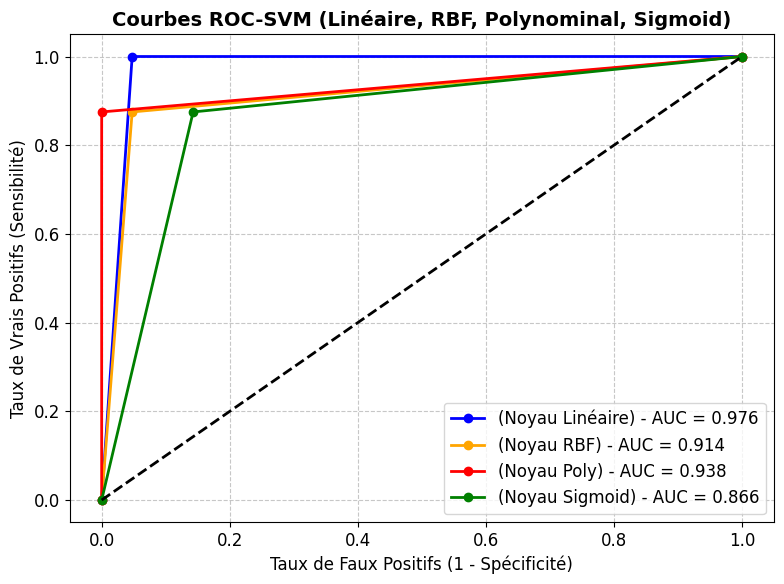

In [24]:
#Sans SMOTE

fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_lin)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)  # ROC pour le modèle SVC avec noyau RBF
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_poly)
fpr_sig, tpr_sig, _ = roc_curve(y_test, y_pred_sig)

auc_lin = auc(fpr_lin, tpr_lin)  # AUC pour le modèle SVC avec noyau linéaire
auc_rbf = auc(fpr_rbf, tpr_rbf)  # AUC pour le modèle SVC avec noyau RBF
auc_poly = auc(fpr_poly, tpr_poly)
auc_sig = auc(fpr_sig, tpr_sig)

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin, tpr_lin, label=f'(Noyau Linéaire) - AUC = {auc_lin:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf, tpr_rbf, label=f'(Noyau RBF) - AUC = {auc_rbf:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')
plt.plot(fpr_poly, tpr_poly, label=f'(Noyau Poly) - AUC = {auc_poly:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='red', color='red')
plt.plot(fpr_sig, tpr_sig, label=f'(Noyau Sigmoid) - AUC = {auc_sig:.3f}', linewidth=2, marker='o', markersize=6, markerfacecolor='green', color='green')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)

plt.rcParams['font.size'] = 12
plt.title('Courbes ROC-SVM (Linéaire, RBF, Polynominal, Sigmoid)', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM.png")
plt.show()

In [25]:
models = {
    "Linear": y_pred_lin,
    "RBF": y_pred_rbf,
    "Poly": y_pred_poly,
    "Sigmoid": y_pred_sig
}

# Calcul de la précision (Accuracy) pour chaque modèle
accuracy_scores = {kernel: accuracy_score(y_test, y_pred) for kernel, y_pred in models.items()}

# Calcul du F1-score pour chaque modèle
f1_scores = {kernel: f1_score(y_test, y_pred) for kernel, y_pred in models.items()}
recall_scores = {kernel: recall_score(y_test, y_pred) for kernel, y_pred in models.items()}
precision_scores = {kernel: precision_score(y_test, y_pred) for kernel, y_pred in models.items()}

auc_scores = {
    "Linear": auc_lin,
    "RBF": auc_rbf,
    "Poly": auc_poly,
    "Sigmoid": auc_sig
}

# Création d'un DataFrame pour afficher les résultats
df_results = pd.DataFrame({
    "Kernel": accuracy_scores.keys(),
    "Accuracy": [round(acc, 5) for acc in accuracy_scores.values()],
    "F1-score": [round(f1, 5) for f1 in f1_scores.values()],
    "Precision": [round(prec, 5) for prec in precision_scores.values()],
    "Recall": [round(rec, 5) for rec in recall_scores.values()],
    "AUC-ROC": [round(auc_val, 5) for auc_val in auc_scores.values()]
})

# Affichage du tableau des résultats
print("Table de comparaison du modèle SVM avec des noyaux")
print(tabulate(df_results, headers='keys', tablefmt='pretty', showindex=False))

Table de comparaison du modèle SVM avec des noyaux
+---------+----------+----------+-----------+--------+---------+
| Kernel  | Accuracy | F1-score | Precision | Recall | AUC-ROC |
+---------+----------+----------+-----------+--------+---------+
| Linear  | 0.96552  | 0.94118  |  0.88889  |  1.0   | 0.97619 |
|   RBF   | 0.93103  |  0.875   |   0.875   | 0.875  | 0.91369 |
|  Poly   | 0.96552  | 0.93333  |    1.0    | 0.875  | 0.9375  |
| Sigmoid | 0.86207  | 0.77778  |    0.7    | 0.875  | 0.86607 |
+---------+----------+----------+-----------+--------+---------+


## 6. Critique

On observe que les noyaux linéaire et RBF ne montrent aucune variation dans leurs métriques d’évaluation avant et après l’application de SMOTE. Cette stabilité est cohérente avec les découvertes de Shatnawi, Raed (2012) selon lesquelles un suréchantillonnage de la classe minoritaire par un facteur de 2 ou 3 n’entraîne pas de modification notable de l’AUC pour un modèle SVM, comme en témoignent les valeurs inchangées de l’AUC pour le noyau linéaire (0.97619) et RBF (0.91369). En revanche, le noyau polynomial subit une baisse de performance, avec une Accuracy passant de 0.96552 à 0.86207 et un F1-Score diminuant de 0.93333 à 0.800, bien que le Recall augmente de 0.875 à 1.0. Cette dégradation peut s’expliquer par le fait que SMOTE, en générant des échantillons synthétiques, modifie la frontière de décision, ce qui semble défavoriser la capacité de séparation du noyau polynomial, un effet moins marqué sur les noyaux linéaires. Par ailleurs, le noyau Sigmoid conserve des métriques identiques, suggérant une insensibilité à l’application de SMOTE. Si l’on conclut que ce jeu de données ne se prête pas pleinement à SMOTE lorsque l’objectif est d’optimiser l’Accuracy ou l’AUC, il convient toutefois de noter que l’amélioration du Recall pour le noyau polynomial pourrait être bénéfique selon les priorités de l’analyse.

**Nous proposons le modèle SVM avec noyau linéaire (SMOTE/non SMOTE n'a pas d'importance car ils donnent les mêmes résultats) dans ce projet afin de le comparer avec d'autres modèles de classification.**

## 7. Exporter les variables

In [26]:
roc_data_svm = {
    'fpr_svm': fpr_lin_smote,
    'tpr_svm': tpr_lin_smote,
    'auc_svm': auc_lin_smote,
    'pred_svm': y_pred_lin_smote,
    
}

with open('Variables/roc_data_svm.pkl', 'wb') as file:
    pickle.dump(roc_data_svm, file)
print("Les données ont été enregistrées avec succès dans 'roc_data_svm.pkl'.")

Les données ont été enregistrées avec succès dans 'roc_data_svm.pkl'.
